# Data Cleaning

In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 47 kB/s 
     |████████████████████████████████| 199 kB 65.3 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=a8a60bb472e3a9c635714a3e0f0cbcc3b65df92742d9bc1bb4d1b880b5b3fcfe
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [2]:
# import necessary libraries.

import requests
import warnings
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.sql.types import FloatType

from pyspark.ml.feature import VectorAssembler,StringIndexer, VectorIndexer
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import GBTRegressor
from pyspark.ml import Pipeline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import calendar
import os
from math import radians, cos, sin, asin, sqrt

In [3]:
warnings.filterwarnings('ignore')

In [4]:
# Download Training dataset file.

URL = "https://www.dropbox.com/s/cem9ea35wllfsqg/train.csv?dl=1"
response = requests.get(URL)
open("train.csv", "wb").write(response.content)

200589097

In [5]:
spark = SparkSession.builder.master("local[1]").appName("SparkByExamples.com").getOrCreate()
df = spark.read.csv("./train.csv", header=True)
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- vendor_id: string (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- dropoff_datetime: string (nullable = true)
 |-- passenger_count: string (nullable = true)
 |-- pickup_longitude: string (nullable = true)
 |-- pickup_latitude: string (nullable = true)
 |-- dropoff_longitude: string (nullable = true)
 |-- dropoff_latitude: string (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- trip_duration: string (nullable = true)



In [6]:
df.show()

+---------+---------+-------------------+-------------------+---------------+-------------------+------------------+-------------------+------------------+------------------+-------------+
|       id|vendor_id|    pickup_datetime|   dropoff_datetime|passenger_count|   pickup_longitude|   pickup_latitude|  dropoff_longitude|  dropoff_latitude|store_and_fwd_flag|trip_duration|
+---------+---------+-------------------+-------------------+---------------+-------------------+------------------+-------------------+------------------+------------------+-------------+
|id2875421|        2|2016-03-14 17:24:55|2016-03-14 17:32:30|              1|-73.982154846191406|40.767936706542969|-73.964630126953125|40.765602111816406|                 N|          455|
|id2377394|        1|2016-06-12 00:43:35|2016-06-12 00:54:38|              1|-73.980415344238281|40.738563537597656|-73.999481201171875|40.731151580810547|                 N|          663|
|id3858529|        2|2016-01-19 11:35:24|2016-01-19 12:

In [7]:
# Check for NaN or null values

df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---+---------+---------------+----------------+---------------+----------------+---------------+-----------------+----------------+------------------+-------------+
| id|vendor_id|pickup_datetime|dropoff_datetime|passenger_count|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|store_and_fwd_flag|trip_duration|
+---+---------+---------------+----------------+---------------+----------------+---------------+-----------------+----------------+------------------+-------------+
|  0|        0|              0|               0|              0|               0|              0|                0|               0|                 0|            0|
+---+---------+---------------+----------------+---------------+----------------+---------------+-----------------+----------------+------------------+-------------+



In [8]:
# Removing id from `id` column.

df = df.withColumn("id", expr("replace(id, 'id', '')"))

In [9]:
# Covert Datatype of the dataframe.

df = df.withColumn("id",df.id.cast('int'))
df = df.withColumn("vendor_id", df.vendor_id.cast('int'))
df = df.withColumn("pickup_datetime", to_timestamp(df.pickup_datetime, "yyyy-MM-dd HH:mm:ss"))
df = df.withColumn("dropoff_datetime", to_timestamp(df.dropoff_datetime, "yyyy-MM-dd HH:mm:ss"))
df = df.withColumn("passenger_count",df.passenger_count.cast('int'))
df = df.withColumn("pickup_longitude",df.pickup_longitude.cast('float'))
df = df.withColumn("pickup_latitude",df.pickup_latitude.cast('float'))
df = df.withColumn("dropoff_longitude",df.dropoff_longitude.cast('float'))
df = df.withColumn("dropoff_latitude",df.dropoff_latitude.cast('float'))
df = df.withColumn('store_and_fwd_flag', F.when(df.store_and_fwd_flag == 'N', 0).otherwise(1))
df = df.withColumn("trip_duration",df.trip_duration.cast('int'))

In [10]:
# Check for columns data types

for col in df.dtypes:
    print(col[0]+" , "+col[1])

id , int
vendor_id , int
pickup_datetime , timestamp
dropoff_datetime , timestamp
passenger_count , int
pickup_longitude , float
pickup_latitude , float
dropoff_longitude , float
dropoff_latitude , float
store_and_fwd_flag , int
trip_duration , int


In [11]:
# Calculate difference in dropoff and pickup time

df = df.withColumn('diff_in_dropff_and_pickup',df["dropoff_datetime"].cast("double") - df['pickup_datetime'].cast("double"))

In [12]:
# Calculate the difference between trip duration and the difference of the pickup and dropoff time

df = df.withColumn('diff_in_trip_duration_and_manual_calc_time',df["trip_duration"].cast("double") - df['diff_in_dropff_and_pickup'].cast("double"))

In [13]:
# Checking for unique values in `diff_in_trip_duration_and_manual_calc_time`

df.select('diff_in_trip_duration_and_manual_calc_time').distinct().collect()

[Row(diff_in_trip_duration_and_manual_calc_time=0.0)]

In [14]:
# Checking if trip duration is 0 or negative, if there then we can remove it.

df.filter(df.trip_duration <= 0).count()

0

In [15]:
# Checking for unique values in `store_and_fwd_flag`

df.select('store_and_fwd_flag').distinct().collect()

[Row(store_and_fwd_flag=1), Row(store_and_fwd_flag=0)]

In [16]:
# Calculate distance between two latitute and longtitude.

def distance(pickUpLat1, dropOffLat2, pickUpLon1, dropOffLon2):
    longitude = radians(dropOffLon2) - radians(pickUpLon1)
    x = sin(longitude / 2)**2 + cos(radians(pickUpLat1)) * cos(radians(dropOffLat2)) * sin(longitude / 2)**2
 
    temp = 2 * asin(sqrt(x))
    earth_radius = 6371
    return(temp * earth_radius)

In [17]:
# Calculating distance between pickup and dropoff latitude and longtitude.

udf_func = udf(distance, FloatType())
df = df.withColumn("distance", udf_func(df.pickup_latitude, df.dropoff_latitude, df.pickup_longitude, df.dropoff_longitude))

In [18]:
# distance is in K.M.

df.select("distance").show()

+----------+
|  distance|
+----------+
| 2.4444735|
| 2.6599078|
|  3.669969|
| 0.3108382|
|0.01808935|
| 1.2867697|
| 1.6197599|
|  6.528439|
| 1.9105701|
| 1.1227313|
| 2.7310188|
| 4.8806133|
| 2.9884133|
| 1.3675101|
| 2.4467576|
|0.94180226|
| 1.1335393|
| 0.7535885|
| 3.4582636|
| 1.0207591|
+----------+
only showing top 20 rows



In [19]:
# Only keep records where distance between non overlapped points

print("Count unique values Before filtering for distance < 0 is ", df.count()) 
df = df.filter(df.distance > 0)

Count unique values Before filtering for distance < 0 is  1458644


In [20]:
# Counting total number of unique values in dataframe.

df.count()

1452028

In [21]:
if os.path.isdir('train-cleaned') == False:
    df.coalesce(1).write.csv("train-cleaned", header=True)

# Data Visualization

In [22]:
# Printing column types.

for col in df.dtypes:
    print(col[0]+" , "+col[1])

id , int
vendor_id , int
pickup_datetime , timestamp
dropoff_datetime , timestamp
passenger_count , int
pickup_longitude , float
pickup_latitude , float
dropoff_longitude , float
dropoff_latitude , float
store_and_fwd_flag , int
trip_duration , int
diff_in_dropff_and_pickup , double
diff_in_trip_duration_and_manual_calc_time , double
distance , float


In [23]:
# Get distance and trip_duration column.
distance = df.select('distance').toPandas().values;
trip_duration = df.select('trip_duration').toPandas().values;

Text(0, 0.5, 'time')

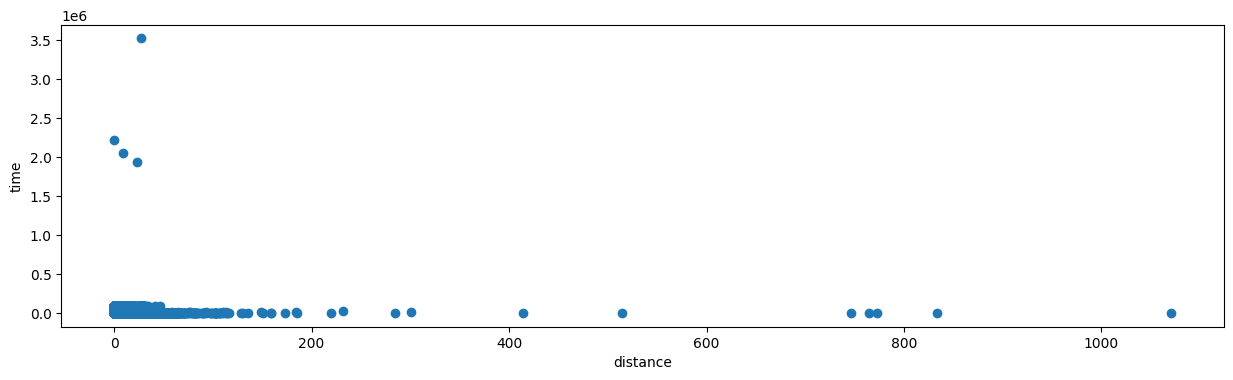

In [24]:
# Scatter plot with distance and trip_duration.

figure(figsize=(15, 4), dpi=100)

plt.scatter(distance, trip_duration)
plt.xlabel("distance")
plt.ylabel("time")

Text(0, 0.5, 'log time')

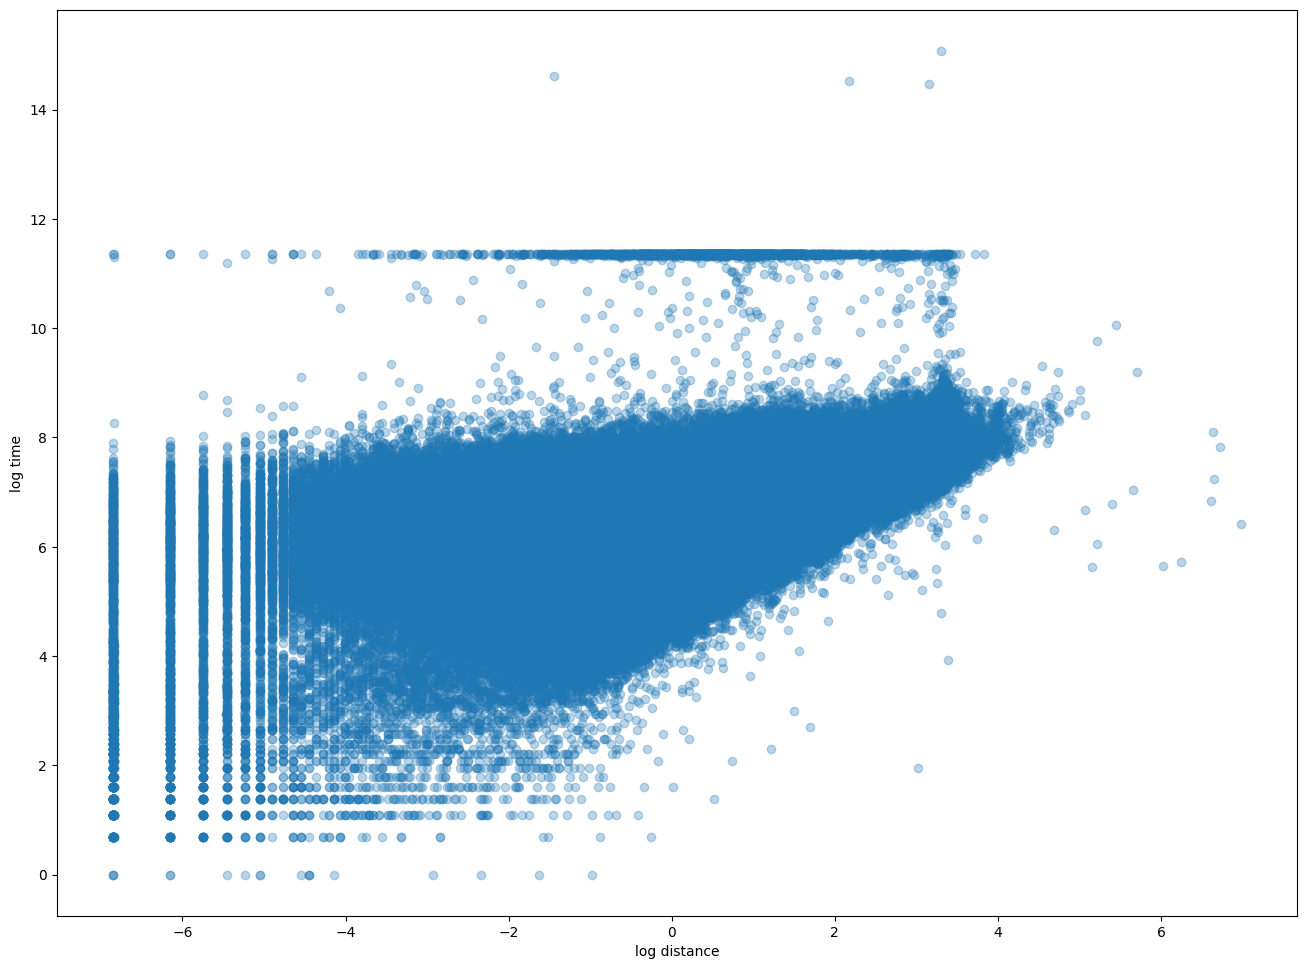

In [25]:
# Scatter plot between log distance and log time.

figure(figsize=(16, 12), dpi=100)
plt.scatter(np.log(distance), np.log(trip_duration), alpha=0.3)
plt.xlabel("log distance")
plt.ylabel("log time")

In [26]:
# filtered data where trip_duration is less than 3 hours and distance is less than 200 K.M.

df_filtered = df.filter((df.trip_duration < 10800) & (df.distance < 200))

distance_filtered = df_filtered.select('distance').toPandas()['distance']
trip_duration_filtered = df_filtered.select('trip_duration').toPandas()['trip_duration']

Text(0, 0.5, 'time')

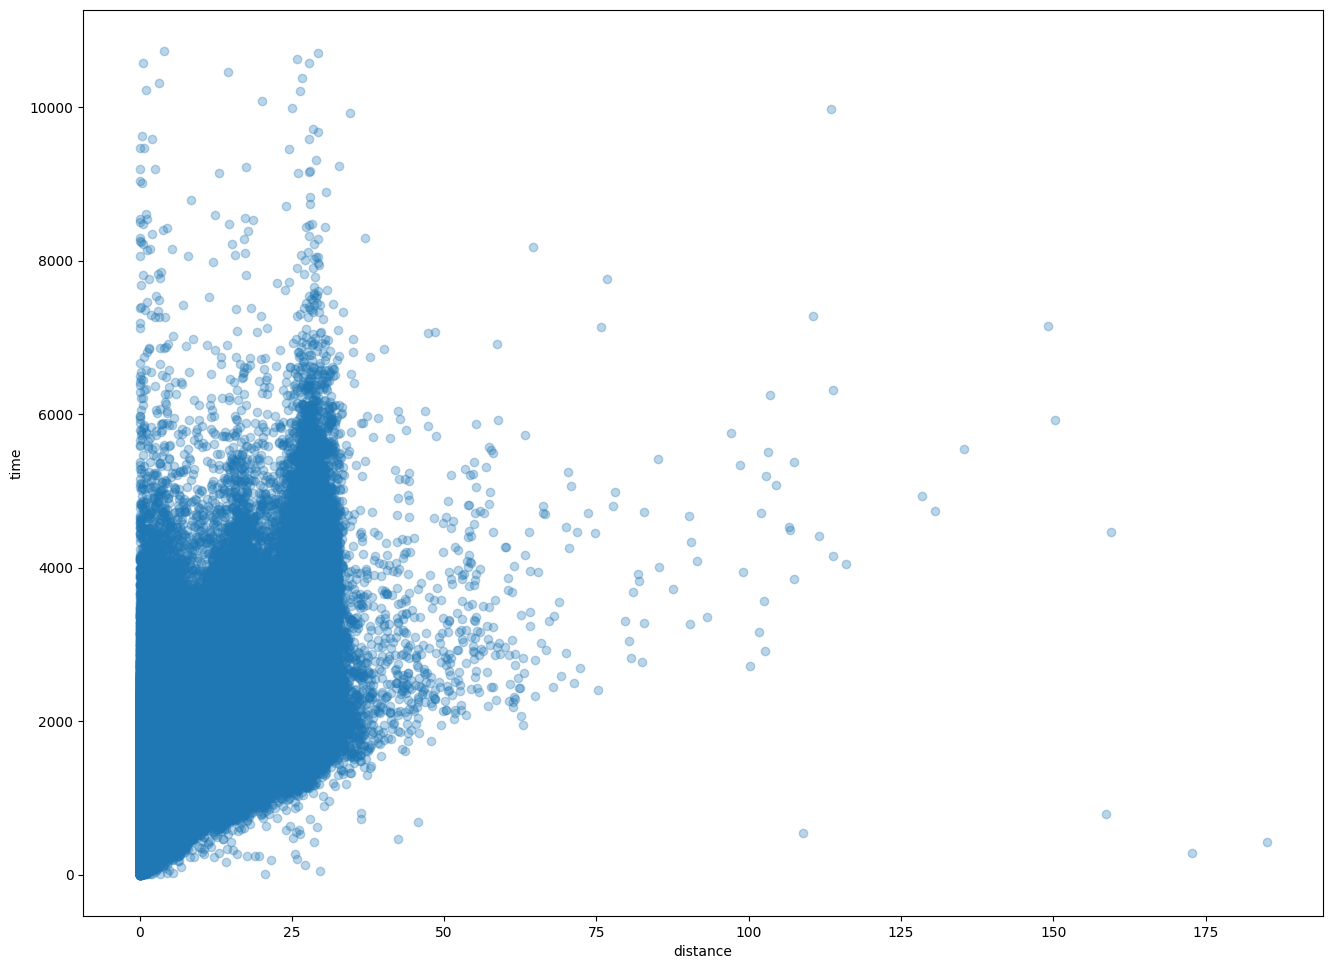

In [27]:
# Scatter plot between distance and time with filtered data.

figure(figsize=(16, 12), dpi=100)
plt.scatter(distance_filtered, trip_duration_filtered, alpha=0.3)
plt.xlabel("distance")
plt.ylabel("time")

Text(0, 0.5, 'log time')

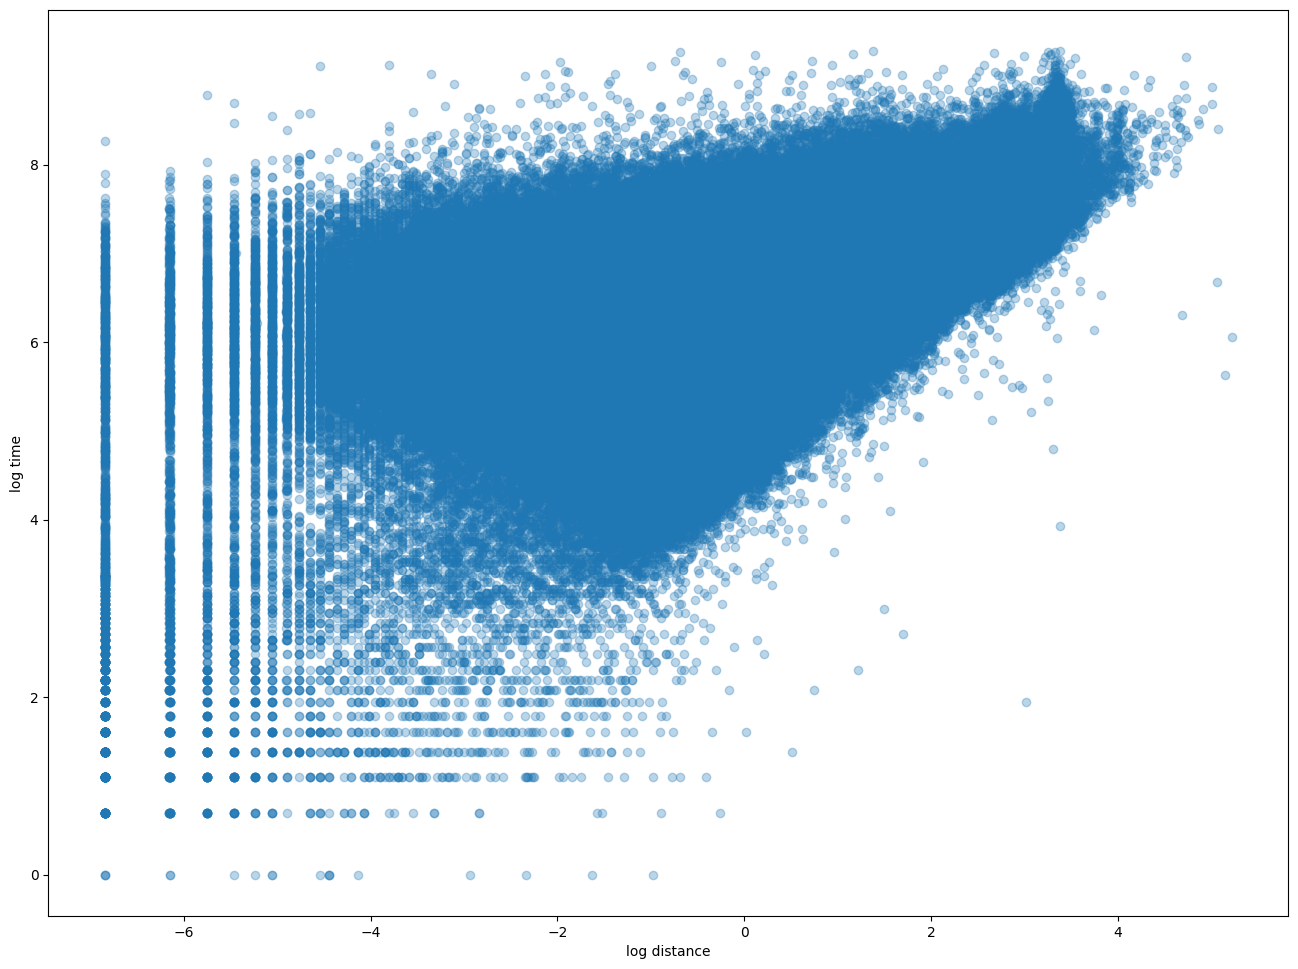

In [28]:
# Scatter plot between log distance and log time with filtered data.

figure(figsize=(16, 12), dpi=100)
plt.scatter(np.log(distance_filtered), np.log(trip_duration_filtered), alpha=0.3)
plt.xlabel("log distance")
plt.ylabel("log time")

In [29]:
# Now get mean trip duration for each day of the week

df_day = df.select(df["pickup_datetime"], df["trip_duration"], df["distance"], df['passenger_count'])
df_day = df_day.withColumn('day_name', date_format(df["pickup_datetime"], "E"))

df_avg_time_per_ride = df_day.groupBy("day_name").mean("trip_duration")

df_avg_time_per_ride.show()

+--------+------------------+
|day_name|avg(trip_duration)|
+--------+------------------+
|     Sun| 903.5534951171725|
|     Mon| 899.5865896337901|
|     Thu|1009.0720398970399|
|     Sat| 950.2920859841474|
|     Wed|  977.250365696257|
|     Tue| 985.6849446062985|
|     Fri| 991.7176962315453|
+--------+------------------+



In [30]:
df_avg_distance = df_day.groupBy("day_name").mean("distance")

df_avg_distance.show()

+--------+------------------+
|day_name|     avg(distance)|
+--------+------------------+
|     Sun|3.6975473902878306|
|     Mon|3.6643402349332534|
|     Thu| 3.420071067214853|
|     Sat|3.1484038388489552|
|     Wed|3.3351171537641595|
|     Tue| 3.343571688002631|
|     Fri| 3.378114635503098|
+--------+------------------+



In [31]:
df_avg_passenger_count_per_ride = df_day.groupBy("day_name").mean("passenger_count")

df_avg_passenger_count_per_ride.show()

+--------+--------------------+
|day_name|avg(passenger_count)|
+--------+--------------------+
|     Sun|  1.7169399918748103|
|     Mon|  1.6340634663722553|
|     Thu|  1.6383802169516455|
|     Sat|  1.7290689901364704|
|     Wed|   1.632855299010469|
|     Tue|   1.635689795271221|
|     Fri|   1.661890744028224|
+--------+--------------------+



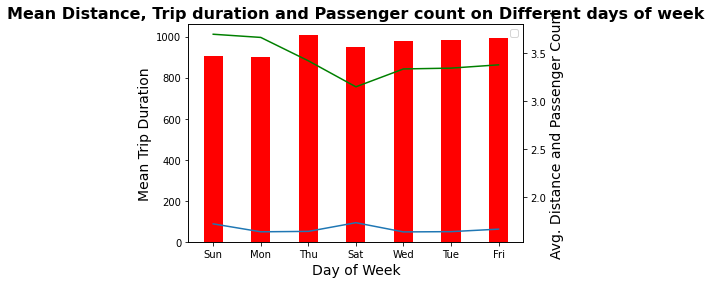

In [32]:
# Bar chart for Mean Trip duration for each day of the week.

fig, first_axes = plt.subplots()
x = df_avg_time_per_ride.toPandas()['day_name'].values
y1 = df_avg_time_per_ride.toPandas()['avg(trip_duration)'].values
y2 = df_avg_distance.toPandas()['avg(distance)'].values
y3 = df_avg_passenger_count_per_ride.toPandas()['avg(passenger_count)'].values

second_axes = first_axes.twinx()
mean_trip_duration = first_axes.bar(x, y1, color ='red',width = 0.4)
mean_distance = second_axes.plot(x, y2, c="green")
mean_passenger_count = second_axes.plot(x, y3)

first_axes.set_xlabel('Day of Week', fontweight='normal', fontsize=14)
first_axes.set_ylabel('Mean Trip Duration', fontweight='normal', fontsize=14)
second_axes.set_ylabel('Avg. Distance and Passenger Count', fontweight='normal', fontsize=14)

second_axes.legend((mean_distance, mean_passenger_count), ('Mean Distance', 'Mean Passenger Count'))

plt.title('Mean Distance, Trip duration and Passenger count on Different days of week', fontweight='bold', fontsize=16)
plt.show()

# K Means Clustering Model

In [33]:
# Remove all trips that have trip_duration more than 50000 seconds which is equivalent to more than 14 hours and less than 10 seconds.
# Remove all trips which total distance is less than 0.5 and more than 200 KM because NYC is not big than 200 KM.

df_trip_duration_filter = df.filter(df.trip_duration < 50000)
df_trip_duration_filter = df_trip_duration_filter.filter(df_trip_duration_filter.trip_duration > 10)

df_lr = df_trip_duration_filter.filter(df_trip_duration_filter.distance > 0.5)
df_lr = df_lr.filter(df_lr.distance < 200)

print(df_lr.count())


1252263


In [34]:
# Use the pickup datetime column to get hour of the day, day of the week, year, month, and hour

from pyspark.sql.functions import col
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")

df_lr = df_lr.withColumn('day_week', date_format(col("pickup_datetime"), "u"))
df_lr = df_lr.withColumn('year', date_format(col("pickup_datetime"), "y"))
df_lr = df_lr.withColumn('month', date_format(col("pickup_datetime"), "M"))
df_lr = df_lr.withColumn('hour', date_format(col("pickup_datetime"), "H"))

df_lr = df_lr.withColumn("day_week",col("day_week").cast("int"))
df = df_lr.withColumn("year",col("year").cast("int"))
df_lr = df_lr.withColumn("month",col("month").cast("int"))
df_lr = df_lr.withColumn("hour",col("hour").cast("int"))


X = df_lr.select(col('day_week'), col('year'), col('month'), col('hour'), col('pickup_latitude'), col('pickup_longitude'),col('dropoff_latitude'), col('dropoff_longitude'), col('distance')).toPandas()

In [35]:
# Use StandardScaler to set all the columns in the dataframe to the same scale
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()                   # Scale the input values
scaled_X = scaler.fit_transform(X)

# Print out some rows of the scaled dataframe
for i in range(5):
    print(scaled_X[i])

[-1.55986299  0.         -0.30957673  0.52999428  0.56284556 -0.24057145
  0.4098996   0.20217102 -0.26657689]
[ 1.50754109  0.          1.4748008  -2.11798333 -0.39812097 -0.19739122
 -0.6170672  -0.70907489 -0.22746603]
[-1.04862897  0.         -1.49916175 -0.40458606  0.43205427 -0.16292279
 -1.24500549 -0.86207962 -0.0440952 ]
[ 0.99630708  0.         -1.49916175  1.30881122 -0.27931056 -0.25799505
 -0.07953292 -0.51557477 -0.47675136]
[ 0.48507307  0.          1.4748008   1.30881122  0.23249772  0.08555292
  0.41865571  0.39108299 -0.41629891]


k=1 done
k=2 done
k=3 done
k=4 done
k=5 done
k=6 done
k=7 done
k=8 done
k=9 done
k=10 done


<Figure size 800x600 with 0 Axes>

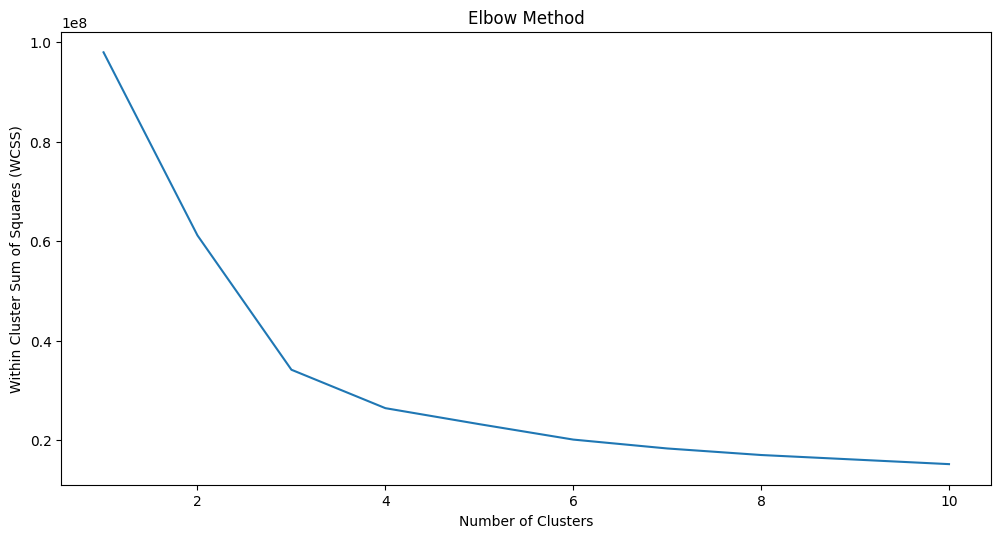

In [36]:
# Determine the optimal number of clusters using the Elbow Method
# For more info on elbow method: https://towardsdatascience.com/clustering-using-k-means-with-implementation-40988620a973
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6), dpi=100)

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0, n_init=10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    print('k='+str(i)+ ' done')

plt.figure(figsize=(12, 6), dpi=100)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Within Cluster Sum of Squares (WCSS)')
plt.show()

In [37]:
# We can see that the graph above levels off at around k=5. So we will use that as our number of clusters
# Now we will create a k-means clustering model that uses 5 clusters (k=5)
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=0)
clusters = kmeans.fit_predict(scaled_X)

cluster
0    330872
1    431065
2    411604
3     78722
Name: cluster, dtype: int64


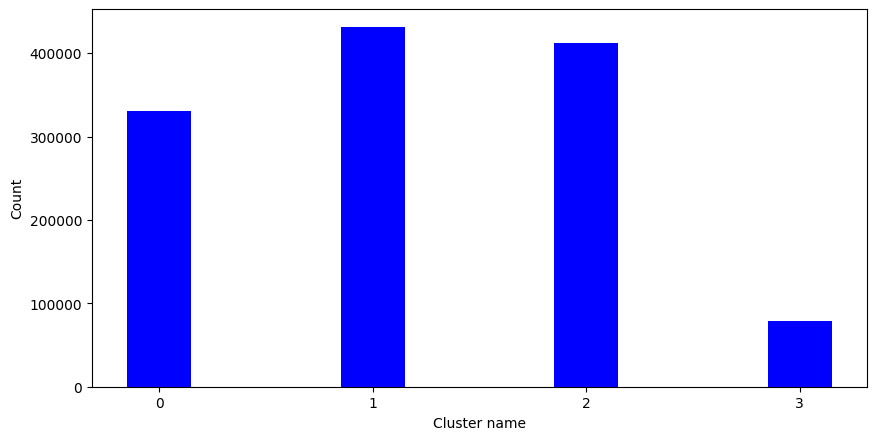

In [38]:
# Graph out the size of each cluster

X['cluster'] = clusters
cluster_counts = X.groupby(['cluster'])['cluster'].count()

print(cluster_counts.head())

plt.figure(figsize=(10, 5), dpi=100)
plt.bar(['0', '1', '2', '3'], cluster_counts.values, color='blue', width = 0.3)
plt.xlabel('Cluster name')
plt.ylabel('Count')
plt.show()

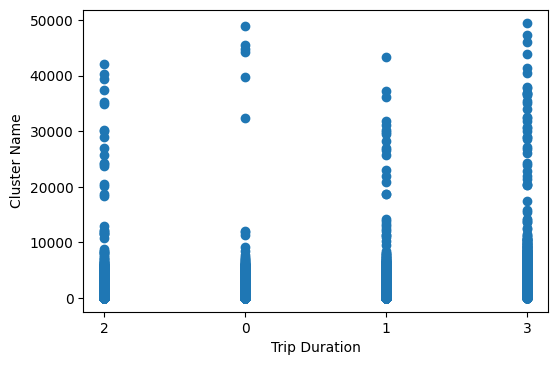

In [39]:
import numpy as np

plt.figure(figsize=(6, 4), dpi=100)
plt.scatter(X['cluster'].astype(str), df_lr.select('trip_duration').toPandas()['trip_duration'])
plt.xlabel('Trip Duration')
plt.ylabel('Cluster Name')
plt.show()


# Linear Regression Model

In [40]:
# Remove all trips that have trip_duration more than 50000 seconds which is equivalent to more than 14 hours and less than 10 seconds.
# Remove all trips which total distance is less than 0.5 and more than 200 KM because NYC is not big than 200 KM.

df_trip_duration_filter = df.filter(df.trip_duration < 50000)
df_trip_duration_filter = df_trip_duration_filter.filter(df_trip_duration_filter.trip_duration > 10)

df_lr = df_trip_duration_filter.filter(df_trip_duration_filter.distance > 0.5)
df_lr = df_lr.filter(df_lr.distance < 200)

In [41]:
# Get day of week, month, and quarter from pickup time.
df_lr = df_lr.withColumn('day_of_week', dayofweek('pickup_datetime'))
df_lr = df_lr.withColumn('month_of_year', month('pickup_datetime'))
df_lr = df_lr.withColumn('quarter_of_year', quarter('pickup_datetime'))

In [42]:
df_lr.show(5)

+-------+---------+-------------------+-------------------+---------------+----------------+---------------+-----------------+----------------+------------------+-------------+-------------------------+------------------------------------------+---------+--------+----+-----+----+-----------+-------------+---------------+
|     id|vendor_id|    pickup_datetime|   dropoff_datetime|passenger_count|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|store_and_fwd_flag|trip_duration|diff_in_dropff_and_pickup|diff_in_trip_duration_and_manual_calc_time| distance|day_week|year|month|hour|day_of_week|month_of_year|quarter_of_year|
+-------+---------+-------------------+-------------------+---------------+----------------+---------------+-----------------+----------------+------------------+-------------+-------------------------+------------------------------------------+---------+--------+----+-----+----+-----------+-------------+---------------+
|2875421|        2|2016-03-14 1

In [43]:
# Citation: https://spark.apache.org/docs/latest/ml-classification-regression.html#linear-regression

# Spliting data into train and test data.
train_lr, test_lr = df_lr.randomSplit(weights=[0.8,0.2], seed=200)

# remove unnecessary features.
cols = ("id","vendor_id", "diff_in_trip_duration_and_manual_calc_time","diff_in_dropff_and_pickup")
train_lr = train_lr.drop(*cols)
test_lr = test_lr.drop(*cols)

# create a feature vector for training dataset.
feature_train = VectorAssembler().setInputCols(['day_of_week', 'month_of_year', 'quarter_of_year','pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'distance']).setOutputCol("vectorized_features")
feature_train_df = feature_train.transform(train_lr)

# create a feature vector for testing dataset.
feature_test = VectorAssembler().setInputCols(['day_of_week','month_of_year','quarter_of_year', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'distance']).setOutputCol("vectorized_features")
feature_test_df = feature_test.transform(test_lr)

# creating linear regression model.
linear_regression_model = LinearRegression(featuresCol = 'vectorized_features', labelCol = 'trip_duration', maxIter=10, solver="normal", epsilon=20)
model = linear_regression_model.fit(feature_train_df)

In [44]:
# Get the summary of the model and printing rmse and accuracy of the model.

summary = model.summary
print("Root Mean Square Error: %f" % summary.rootMeanSquaredError)
print("Coefficient of Determination(Accuracy): ", summary.r2*100, "%")

Root Mean Square Error: 543.259774
Coefficient of Determination(Accuracy):  44.09473424234235 %


In [45]:
# Print coefficients of the model.

print("Coefficients: " + str(model.coefficients))

Coefficients: [13.34838517078632,15.347658149067307,20.753716321819326,-218.88666663344125,-298.66979829001275,-398.2140642416272,-1189.7313638160342,87.08650518186477]


In [46]:
# Print Accuracy of the Linear Regression model.

prediction_lr = model.transform(feature_test_df)
pred_evaluator_lr = RegressionEvaluator(predictionCol="prediction", labelCol="trip_duration",metricName="r2")
print("Coefficient of Determination(Accuracy): ", pred_evaluator_lr.evaluate(prediction_lr)*100, "%")

Coefficient of Determination(Accuracy):  47.19198106167286 %


# Gradient Boosted Trees

In [47]:
# Copy linear regression dataframe to gradient boosted trees dataframe.

df_gbt = df_lr

In [48]:
# Split training and testing data.
train_gbt, test_gbt = df_gbt.randomSplit(weights=[0.8,0.2], seed=200)

# remove unnecessary features.
cols = ("id","vendor_id", "diff_in_trip_duration_and_manual_calc_time","diff_in_dropff_and_pickup")
train_gbt = train_gbt.drop(*cols)
test_gbt = test_gbt.drop(*cols)

# create a feature vector for training dataset.
feature_train = VectorAssembler().setInputCols(['day_of_week', 'month_of_year', 'quarter_of_year','pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'distance']).setOutputCol("vectorized_features")
feature_train_df = feature_train.transform(train_gbt)

# create a feature vector for testing dataset.
feature_test = VectorAssembler().setInputCols(['day_of_week','month_of_year','quarter_of_year', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'distance']).setOutputCol("vectorized_features")
feature_test_df = feature_test.transform(test_gbt)

In [49]:
# Citation: https://spark.apache.org/docs/latest/ml-classification-regression.html#gradient-boosted-tree-classifier

featureIndexer = VectorIndexer(inputCol="vectorized_features", outputCol="indexedFeatures", maxCategories=3).fit(feature_train_df)

gbt = GBTRegressor(featuresCol="indexedFeatures", labelCol="trip_duration", maxIter=100)

# gradient boosted trees in pipeline.
pipeline = Pipeline(stages=[featureIndexer, gbt])

# creating gradient boosted trees model.
model = pipeline.fit(feature_train_df)

In [50]:
# predict
gbt_predictions = model.transform(feature_test_df)

# Get Evaluator.
gbt_evaluator = RegressionEvaluator(labelCol="trip_duration", predictionCol="prediction", metricName="rmse")

# Get root mean square error for gradient boosted trees model.
rmse = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 415.495


In [51]:
# prediction evaluator.
gbt_pred_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="trip_duration",metricName="r2")

# Print an accuracy of the gradient boosted trees model.
print("Coefficient of Determination(Accuracy): ", gbt_pred_evaluator.evaluate(gbt_predictions)*100, "%")

Coefficient of Determination(Accuracy):  64.5060924155951 %
